# E9. Movielens 영화 추천

### 실습 목차
1. 데이터 로드, 전처리, EDA
2. CSR Matrix
3. 영화 추천 (AlternatingLeastSquares)
4. 영화 추천 (Singular Value Decomposition)
5. 회고

## 1. 데이터 로드, 전처리, EDA

In [1]:
!ls

drive  sample_data


In [2]:
!pip install implicit

     |████████████████████████████████| 1.1 MB 5.3 MB/s 
  Created wheel for implicit: filename=implicit-0.4.4-cp37-cp37m-linux_x86_64.whl size=3409590 sha256=22a4a60bc77e0dc37c9777224633d4b8b51dc811eb63986589b24bbc2ccc1de3
  Stored in directory: /root/.cache/pip/wheels/44/7e/7d/a17324ea207cfbe76aca878b5b8ca0aa932cf55d163329be37
Successfully built implicit


In [3]:
# 필요한 모듈 import
import os
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
import matplotlib.pyplot as plt

In [4]:
# 영화 rating data
rating_file_path = '/content/drive/MyDrive/data/e9_movielens/ratings.dat'
ratings_cols = ['user_id','movie_id','rating','timestamp']
ratings = pd.read_csv(rating_file_path, sep='::', names = ratings_cols,engine='python', encoding="ISO-8859-1")
original_data_size = len(ratings)
ratings.head()

,user_id,movie_id,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# 학습에 필요한 열만 남겨둡니다.
using_cols = ['user_id','movie_id','rating']
ratings = ratings[using_cols]
ratings.head(10)

,user_id,movie_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [6]:
# 평점이 3 이상인 영화들을 선호한다고 간주하고, 평점 3 이상인 행만 남깁니다.
ratings = ratings[ratings['rating']>=3]
filtered_data_size = len(ratings)

print(f'original_data_size: {original_data_size}, filtered_data_size: {filtered_data_size}')
print(f'Ratio of Remaining data is {filtered_data_size / original_data_size:.2%}')

original_data_size: 1000209, filtered_data_size: 836478
Ratio of Remaining data is 83.63%


In [7]:
movie_file_path = '/content/drive/MyDrive/data/e9_movielens/movies.dat'
cols = ['movie_id', 'title', 'genre']
movies = pd.read_csv(movie_file_path, sep='::', names=cols, engine='python', encoding='ISO-8859-1')
display(movies)

,movie_id,title,genre
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy
...,...,...,...
3878,3948,Meet the Parents (2000),Comedy
3879,3949,Requiem for a Dream (2000),Drama
3880,3950,Tigerland (2000),Drama
3881,3951,Two Family House (2000),Drama


In [8]:
user_file_path = '/content/drive/MyDrive/data/e9_movielens/users.dat'
cols = ['user_id','Gender','Age','Occupation','Zip-code']
users = pd.read_csv(user_file_path, sep='::', names = cols, engine = 'python', encoding = 'ISO-8859-1')
display(users)

,user_id,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455
...,...,...,...,...,...
6035,6036,F,25,15,32603
6036,6037,F,45,1,76006
6037,6038,F,56,1,14706
6038,6039,F,45,0,01060


In [9]:
# movies dataframe에서 title 영화 제작 연도를 분리
movies['year'] = movies['title'].apply(lambda x: x[-5:-1]).astype(int)
movies['title'] = movies['title'].apply(lambda x: x[:-7])
movies.head(5)

,movie_id,title,genre,year
0,1,Toy Story,Animation|Children's|Comedy,1995
1,2,Jumanji,Adventure|Children's|Fantasy,1995
2,3,Grumpier Old Men,Comedy|Romance,1995
3,4,Waiting to Exhale,Comedy|Drama,1995
4,5,Father of the Bride Part II,Comedy,1995


In [10]:
# 데이터 시각화를 위한 full 데이터프레임 생성
full = pd.merge(ratings, movies, how='inner', on='movie_id')
display(full)

,user_id,movie_id,rating,title,genre,year
0,1,1193,5,One Flew Over the Cuckoo's Nest,Drama,1975
1,2,1193,5,One Flew Over the Cuckoo's Nest,Drama,1975
2,12,1193,4,One Flew Over the Cuckoo's Nest,Drama,1975
3,15,1193,4,One Flew Over the Cuckoo's Nest,Drama,1975
4,17,1193,5,One Flew Over the Cuckoo's Nest,Drama,1975
...,...,...,...,...,...,...
836473,5851,3607,5,One Little Indian,Comedy|Drama|Western,1973
836474,5854,3026,4,Slaughterhouse,Horror,1987
836475,5854,690,3,"Promise, The (Versprechen, Das)",Romance,1994
836476,5938,2909,4,"Five Wives, Three Secretaries and Me",Documentary,1998


In [11]:
# rating이 많이 된 영화 30개
movie_count = full.groupby('title')['user_id'].count()
movie_count.sort_values(ascending=False).head(30)

title
American Beauty                                   3211
Star Wars: Episode IV - A New Hope                2910
Star Wars: Episode V - The Empire Strikes Back    2885
Star Wars: Episode VI - Return of the Jedi        2716
Saving Private Ryan                               2561
Terminator 2: Judgment Day                        2509
Silence of the Lambs, The                         2498
Raiders of the Lost Ark                           2473
Back to the Future                                2460
Matrix, The                                       2434
Jurassic Park                                     2413
Sixth Sense, The                                  2385
Fargo                                             2371
Braveheart                                        2314
Men in Black                                      2297
Schindler's List                                  2257
Princess Bride, The                               2252
Shakespeare in Love                               2213
L.A.

In [12]:
# rating이 각각 5점인 영화 순위
x = full[full['rating']==5]
movie_count = x.groupby('title')['user_id'].count()
print("rating이 5점인 영화 순위")
print(movie_count.sort_values(ascending=False).head(5))
print("------------------------------------------------")

rating이 5점인 영화 순위
title
American Beauty                                   1963
Star Wars: Episode IV - A New Hope                1826
Raiders of the Lost Ark                           1500
Star Wars: Episode V - The Empire Strikes Back    1483
Schindler's List                                  1475
Name: user_id, dtype: int64
------------------------------------------------


- 어떤 영화가 인기가 많을까? American Beauty (1999) 영화를 rating한 사용자들이 가장 많습니다.

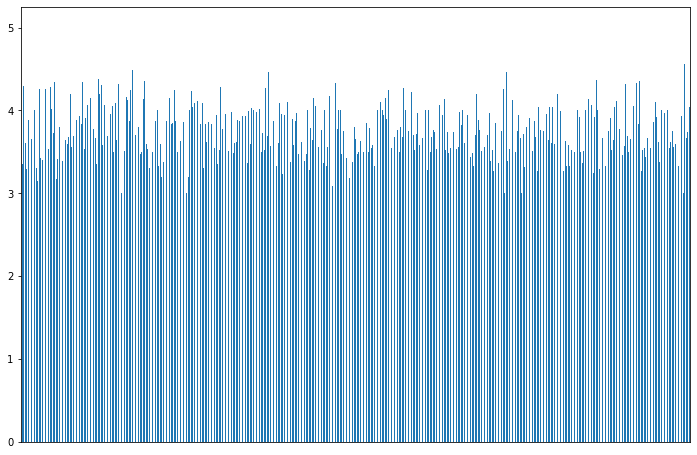

In [13]:
# 영화별 평균 평점 분포
rating_average = full.groupby('title')['rating'].mean()
plt.figure(figsize=(12, 8))
rating_average.plot.bar()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.show()

- rating이 3점 이상인 영화만 필터링했더니 평균 rating은 주로 3~4 사이에 분포해있습니다.

In [14]:
# 평균 rating 점수가 높은 순위
rating_average.sort_values(ascending=False).head(30)

title
Country Life                                                    5.000000
Gate of Heavenly Peace, The                                     5.000000
Schlafes Bruder (Brother of Sleep)                              5.000000
Ulysses (Ulisse)                                                5.000000
Black Sunday (La Maschera Del Demonio)                          5.000000
Bittersweet Motel                                               5.000000
Lured                                                           5.000000
Criminal Lovers (Les Amants Criminels)                          5.000000
Foreign Student                                                 5.000000
Song of Freedom                                                 5.000000
One Little Indian                                               5.000000
Message to Love: The Isle of Wight Festival                     5.000000
Identification of a Woman (Identificazione di una donna)        5.000000
Smashing Time                                

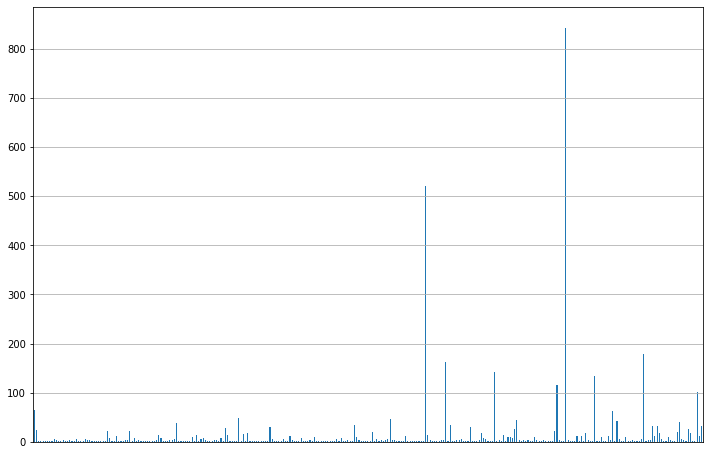

In [15]:
# genre별 영화 개수 분포 시각화
movie_genre = movies.groupby('genre')['title'].count()

plt.figure(figsize=(12, 8))
movie_genre.plot.bar()
ax = plt.gca()
ax.axes.xaxis.set_visible(False)
plt.grid(True)
plt.show()

- 영화 genre의 분포를 보니 몇몇 gnere 들이 눈에 띄게 많은 것을 볼 수 있습니다.

In [16]:
# genre 개수가 많은 순 10위
movie_genre.sort_values(ascending=False).head(10)

genre
Drama             843
Comedy            521
Horror            178
Comedy|Drama      162
Comedy|Romance    142
Drama|Romance     134
Documentary       116
Thriller          101
Action             65
Drama|Thriller     63
Name: title, dtype: int64

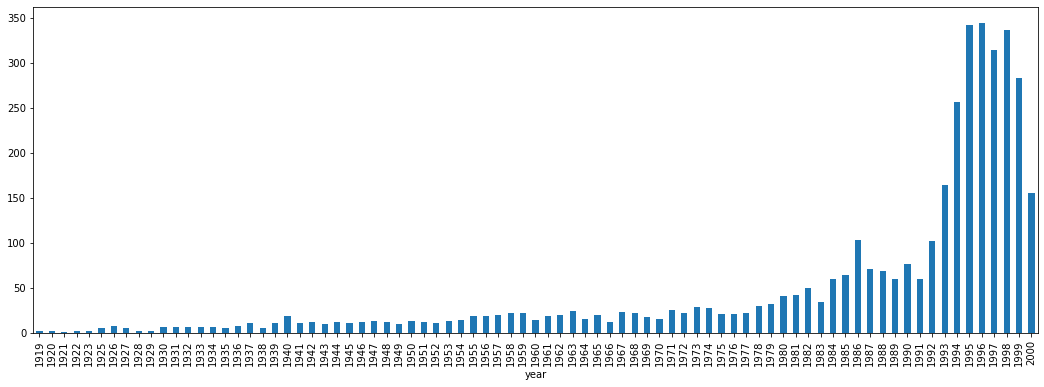

In [17]:
# 연도별 영화 분포
movie_year = movies.groupby('year')['title'].count()
plt.figure(figsize= (18, 6))
movie_year.plot.bar()

- 데이터셋에는 90년대 영화가 많네요.

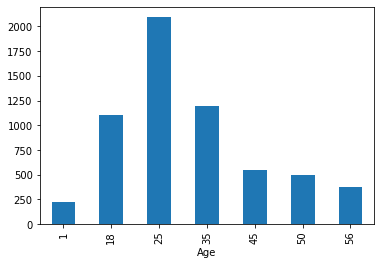

In [18]:
users.groupby('Age')['user_id'].count().plot.bar()

- user의 나이대는 20대가 가장 많습니다.

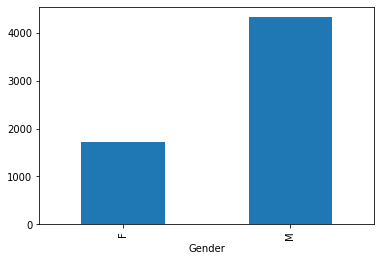

In [19]:
users.groupby('Gender')['user_id'].count().plot.bar()

- user의 성별은 남성이 여성보다 2배 이상 많은 것 같습니다.

In [20]:
# 유저 별로 영화 rating을 얼마나 했는지 통계
user_count = ratings.groupby('user_id')['movie_id'].count()
user_count.describe()

count    6039.000000
mean      138.512668
std       156.241599
min         1.000000
25%        38.000000
50%        81.000000
75%       177.000000
max      1968.000000
Name: movie_id, dtype: float64

In [21]:
print("고유한 movie_id 개수:", movies["movie_id"].nunique())
print("고유한 user_id 개수:", users["user_id"].nunique())

고유한 movie_id 개수: 3883
고유한 user_id 개수: 6040


In [22]:
# 제가 좋아하는 영화를 6개 추가합니다. movie_id로 바꿔서 추가할 것입니다.
my_favorite = ['Jurassic Park' , 'Back to the Future' ,
               'Schindler\'s List' ,'Shawshank Redemption, The' ,
               'Toy Story', 'Jumanji']

index = movies['movie_id'].where(movies['title'].isin(my_favorite))
index = index.dropna().astype(int)
my_favorite = [id for id in index]
print(my_favorite)

# 'Minji'이라는 user_id가 위 영화 평점을 5로 주었다고 가정합니다.
my_playlist = pd.DataFrame({'user_id': ['Minji']*6, 'movie_id': my_favorite, 'rating':[5]*6})

if not ratings.isin({'user_id':['Minji']})['user_id'].any():  # user_id에 'Minji'이라는 데이터가 없다면
    ratings = ratings.append(my_playlist)                           # 위에 임의로 만든 my_favorite 데이터를 추가해 줍니다. 

ratings.tail(10)       # 잘 추가되었는지 확인해 봅시다.

[1, 2, 318, 480, 527, 1270]


,user_id,movie_id,rating
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,Minji,1,5
1,Minji,2,5
2,Minji,318,5
3,Minji,480,5
4,Minji,527,5
5,Minji,1270,5


In [23]:
ratings['user_id'].replace({'Minji': 6041}, inplace = True)

In [24]:
ratings.tail(10)

,user_id,movie_id,rating
1000205,6040,1094,5
1000206,6040,562,5
1000207,6040,1096,4
1000208,6040,1097,4
0,6041,1,5
1,6041,2,5
2,6041,318,5
3,6041,480,5
4,6041,527,5
5,6041,1270,5


## 2. CF(Collaborative Filtering)을 하기 위해 CSR Matrix 생성

In [25]:
# compressed sparse row matrix를 만들고자 합니다.
# 앞에서 ratings 3 이상인 것들로 filtering 해주었으므로 movie id와 user id 인덱싱이 일부 사라졌습니다.
# 그래서 최댓값을 구해주고, 번호가 1부터 시작하기 때문에 1을 더해주었습니다.
num_user = ratings["user_id"].max() + 1
num_movies = ratings['movie_id'].max() + 1
print(num_user)
print(num_movies)

6042
3953


In [26]:
csr_ratings = csr_matrix((ratings.rating, (ratings.user_id, ratings.movie_id)), shape=(num_user, num_movies))
csr_ratings

<6042x3953 sparse matrix of type '<class 'numpy.longlong'>'
	with 836484 stored elements in Compressed Sparse Row format>

## 3. implicit의 AlternatingLeastSquares를 활용한 영화 추천

In [27]:
# implicit 패키지를 활용해서 matrix factorization 학습하기
from implicit.als import AlternatingLeastSquares

# implicit 라이브러리에서 권장하고 있는 부분입니다. 학습 내용과는 무관합니다.
os.environ['OPENBLAS_NUM_THREADS']='1'
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['MKL_NUM_THREADS']='1'

In [28]:
# alternating least squares 모델 정의
als_model = AlternatingLeastSquares(factors=128, regularization=0.01, use_gpu=False, iterations=15, dtype=np.float32)

In [29]:
# input으로 (item * user) 형태로 바꾸어줍니다.
csr_ratings_transpose = csr_ratings.T

# 모델 훈련
als_model.fit(csr_ratings_transpose)

  0%|          | 0/15 [00:00<?, ?it/s]

In [30]:
# 영화 제목을 입력하면, movies 데이터프레임에서 movie_id를 찾아 반환해주는 함수
def movie_id(str):
  return movies['movie_id'].where(movies['title'] == str).dropna().astype(int).values[0]

Minji_id = 6041
jurassic_park = movie_id("Jurassic Park")

In [31]:
Minji_vector, jurassic_park_vector = als_model.user_factors[Minji_id], als_model.item_factors[jurassic_park]
np.dot(Minji_vector, jurassic_park_vector)

0.5517075

- Minji 벡터와 rating을 5점 준 영화(jurassic park)의 벡터 내적이 1 과 가까운 값이 나오고 있습니다. 선호할수록 1과 가까운 값이 나옵니다.

In [32]:
als_model = AlternatingLeastSquares(factors=256, regularization=0.01, use_gpu=False, iterations=50, dtype=np.float32)

# 모델 훈련
als_model.fit(csr_ratings_transpose)

Minji_vector, jurassic_park_vector = als_model.user_factors[Minji_id], als_model.item_factors[jurassic_park]
np.dot(Minji_vector, jurassic_park_vector)

  0%|          | 0/50 [00:00<?, ?it/s]

0.81316435

- 내적이 1과 더 가까워졌네요.

In [33]:
# 제가 5점을 rating한 영화 Toy Story 벡터와 내적을 구해보겠습니다.
toy_story = movie_id("Toy Story")
toy_story_vector = als_model.item_factors[toy_story]
np.dot(Minji_vector, toy_story_vector)

0.7709216

- 선호하는 영화는 내적이 1과 가깝게 나오네요.

In [34]:
# 제가 rating하지 않은 영화 벡터와 내적을 구해보겠습니다.
toy_story_2 = movie_id("Toy Story 2")
vector = als_model.item_factors[toy_story_2]
np.dot(Minji_vector, vector)

0.33467975

- 0.5 이하의 값이 나왔네요!

**내가 좋아하는 영화와 비슷한 영화 추천**

In [35]:
# movies dataframe 에서 movie_id 를 받아서, 영화 제목을 반환하는 함수
def movie_title(index):
  return movies['title'].where(movies['movie_id'] == index).dropna().values[0]

# 영화 제목을 입력으로 받으면, 비슷한 영화를 추천해줍니다.
def get_similar_movie(movie_name: str):
  id = movie_id(movie_name)
  similar_movie = als_model.similar_items(id)   # als_model 의 메서드 사용
  similar_movie = [movie_title(i[0]) for i in similar_movie]
  return similar_movie

get_similar_movie('Toy Story')

['Toy Story',
 'Toy Story 2',
 'Aladdin',
 "Bug's Life, A",
 'Nobody Loves Me (Keiner liebt mich)',
 'Amityville: Dollhouse',
 'Best Men',
 'Falling in Love Again',
 'Impact',
 'Soft Toilet Seats']

- 상위에 toy story와 비슷한 애니메이션이 추천되고 있습니다.

In [36]:
# back to the future와 유사한 영화를 찾아보겠습니다.
get_similar_movie('Back to the Future')

['Back to the Future',
 'Back to the Future Part II',
 "Ferris Bueller's Day Off",
 'Cocoon',
 'When Harry Met Sally...',
 'Bull Durham',
 'Back to the Future Part III',
 'Big',
 'Terminator, The',
 'Anna Karenina']

In [37]:
# shawshank redemption 과 유사한 영화를 찾아보겠습니다.
get_similar_movie('Shawshank Redemption, The')

['Shawshank Redemption, The',
 'Silence of the Lambs, The',
 'Pulp Fiction',
 'GoodFellas',
 'Good Will Hunting',
 'Brother Minister: The Assassination of Malcolm X',
 'Blood, Guts, Bullets and Octane',
 'Abominable Snowman, The',
 "Schindler's List",
 'Skipped Parts']

- 범죄와 관련된 영화가 많이 추천된 것 같습니다.

**내가 좋아할만한 영화 추천**

In [38]:
# user(Minji)에게 영화 20개 추천하기
movie_recommended = als_model.recommend(Minji_id, csr_ratings, N=20, filter_already_liked_items=True)
[movie_title(i[0]) for i in movie_recommended]

['Toy Story 2',
 'Silence of the Lambs, The',
 '12 Angry Men',
 'Indian in the Cupboard, The',
 'Groundhog Day',
 'Good Will Hunting',
 'Dances with Wolves',
 'Firm, The',
 'Beetlejuice',
 'Big',
 'Dragonheart',
 'Hook',
 'Terminator 2: Judgment Day',
 'Fargo',
 'Dead Man Walking',
 'Titanic',
 'Hoop Dreams',
 'Shakespeare in Love',
 'Nutty Professor, The',
 'Braveheart']

In [39]:
# 왜 'Good Will Hunting' 영화를 추천해주었을까? rating한 영화의 기여도를 알아보자.
id = movie_id('Good Will Hunting')
explain = als_model.explain(Minji_id, csr_ratings, itemid=id)
explain = [(movie_title(i[0]), i[1]) for i in explain[1]]

In [40]:
explain

[('Shawshank Redemption, The', 0.09797720532062548),
 ("Schindler's List", 0.029587560622631667),
 ('Jumanji', 0.026312353231894958),
 ('Jurassic Park', 0.02478343730045668),
 ('Back to the Future', 0.0180634674913706),
 ('Toy Story', -0.006046988911489913)]

In [41]:
print('가장 기여를 많이 한 영화: {} \n점수: {}'.format(explain[0][0], explain[0][1]))

가장 기여를 많이 한 영화: Shawshank Redemption, The 
점수: 0.09797720532062548


## 4. SVD(Singular Value Decomposition) 알고리즘을 활용한 추천시스템
- 추천 시스템의 알고리즘을 구현할 때 surprise 라이브러리 활용
- surprise에는 다양한 추천 알고리즘이 구현되어 추천에 활용할 수 있습니다. (basic, k-nn inspired, matrix factorization-based 등등)
- 여기서 사용한 것은 SVD 알고리즘으로, "The famous SVD algorithm, as popularized by Simon Funk during the Netflix Prize. When baselines are not used, this is equivalent to **Probabilistic Matrix Factorization**"라고 설명하고 있다. 간단하게 표현하면, (user 수*item 수) 행렬을 두 개의 저차원 행렬 곱으로 쪼개는 방식으로 weight를 구하는 알고리즘이다.
- https://dschloe.github.io/python/recommendation/recommendation_02/ 이 링크를 참고했습니다.
-https://www.kaggle.com/rounakbanik/movie-recommender-systems 이 링크는 다양한 알고리즘에 대해서 확인해볼 수 있었습니다.

In [42]:
!pip install surprise

     |████████████████████████████████| 11.8 MB 4.5 MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1619441 sha256=1509e65c2b0eaa4abe8f3f4a91eaf4bb46788296b3d8df755f5b768cfe9676eb
  Stored in directory: /root/.cache/pip/wheels/76/44/74/b498c42be47b2406bd27994e16c5188e337c657025ab400c1c
Successfully built scikit-surprise


In [68]:
from surprise import Reader, Dataset, SVD, accuracy
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

# 데이터 변환
reader = Reader()
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', 'rating']], reader)

In [69]:
# The cross_validate() function runs a cross-validation procedure according to the cv argument,
# and computes some accuracy measures.
svd = SVD()   # svd 알고리즘

# 모델 훈련
trainset = data.build_full_trainset()
svd.fit(trainset)

cross_validate(svd, data, measures=['RMSE', 'MAE'], cv=10, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 10 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Fold 6  Fold 7  Fold 8  Fold 9  Fold 10 Mean    Std     
RMSE (testset)    0.6588  0.6582  0.6575  0.6608  0.6566  0.6584  0.6600  0.6607  0.6578  0.6570  0.6586  0.0014  
MAE (testset)     0.5441  0.5430  0.5420  0.5452  0.5414  0.5438  0.5449  0.5456  0.5418  0.5429  0.5435  0.0014  
Fit time          46.83   47.42   47.28   46.44   46.74   46.43   47.09   46.58   46.15   46.00   46.70   0.45    
Test time         1.82    1.32    1.65    1.46    1.21    1.74    1.16    1.69    1.21    1.66    1.49    0.24    


{'fit_time': (46.82817196846008,
  47.423728942871094,
  47.28317856788635,
  46.440207958221436,
  46.74003195762634,
  46.427019119262695,
  47.09216547012329,
  46.576980113983154,
  46.14695167541504,
  46.003376483917236),
 'test_mae': array([0.54407807, 0.54304515, 0.54200574, 0.54515971, 0.54141061,
        0.54384899, 0.54488227, 0.54564214, 0.54176822, 0.54293131]),
 'test_rmse': array([0.65880885, 0.65815815, 0.65745625, 0.66075315, 0.65657764,
        0.65838305, 0.65997302, 0.66069491, 0.65777591, 0.65702547]),
 'test_time': (1.8220486640930176,
  1.3190524578094482,
  1.6491501331329346,
  1.455087661743164,
  1.2062575817108154,
  1.7390964031219482,
  1.1637487411499023,
  1.6854276657104492,
  1.2050459384918213,
  1.6565847396850586)}

훈련 결과, Mean RMSE는 0.6586로 나왔습니다.

In [70]:
# 예측
svd.predict(6041, 1, 5)

Prediction(uid=6041, iid=1, r_ui=5, est=4.699956199570724, details={'was_impossible': False})

In [71]:
svd.predict(6041, 10)

Prediction(uid=6041, iid=10, r_ui=None, est=4.209945962031295, details={'was_impossible': False})

- uid는 사용자 아이디, iid는 item 아이디, r_ui 는 실제 평점, est는 예측 평점
- 어떤 특정 사용자의 특정 영화에 대한 평점을 예측해주고 있습니다. 예측 값이 높을수록 사용자가 이 영화를 선호할 수 있습니다. 예측값이 높은 영화를 사용자에게 추천해주면 좋을 것 같습니다.

In [72]:
# 내가 선호하는 영화 추천
uid = 6041    # user id 를 6041(Minji)로 설정
predictions={}

# 모든 아이템에 대해 uid=6041 예측
for i in range(1, movies['movie_id'].max()+1):
  predict=svd.predict(uid, i)
  predictions[f"{predict[1]}"]=predict[3]

# estimation 점수 내림차순 정렬
predictions = sorted(predictions.items(), reverse=True, key=lambda item:item[1])
top_10 = predictions[:10]
top_10

[('260', 5),
 ('318', 5),
 ('527', 5),
 ('720', 5),
 ('2019', 5),
 ('2762', 5),
 ('1198', 4.998638342834991),
 ('670', 4.965494780588219),
 ('2905', 4.956384949779418),
 ('953', 4.951828003301749)]

In [73]:
[movie_title(int(i[0])) for i in top_10]

['Star Wars: Episode IV - A New Hope',
 'Shawshank Redemption, The',
 "Schindler's List",
 'Wallace & Gromit: The Best of Aardman Animation',
 'Seven Samurai (The Magnificent Seven) (Shichinin no samurai)',
 'Sixth Sense, The',
 'Raiders of the Lost Ark',
 'World of Apu, The (Apur Sansar)',
 'Sanjuro',
 "It's a Wonderful Life"]

- 5점으로 rating한 영화 6개 중 2개가 상위 링크에 있습니다. (쇼생크 탈출, 쉰들러리스트)
- 찾아보니까 상위 estimate된 영화들 중에는 일본 사무라이 영화가 있는데 왜 상위에 추천해주었는지 의문입니다.

## 5. 회고
영화, 상품 등을 이용자에게 추천해주는 알고리즘은 실제 적용이 많이 되고 있는 알고리즘이다. 대표적으로는 넷플릭스 같은 ott 플랫폼이 고객들에게 영화를 추천해주는 서비스를 제공한다. 이러한 추천 알고리즘을 어떻게 설계할 수 있을지 오늘 실습에서 배울 수 있었다. 크게 content based recommendation(아이템의 컨텐츠, 특징 등을 활용한 추천)과 collaborative filtering recommendation(이용자와 유사한 다른 이용자로부터 추천)으로 나눌 수 있는데, 이 중 cf 알고리즘을 활용해서 영화를 추천해봤다. 아쉬웠던 것은, 데이터셋이 90년대 영화 위주여서 최근 영화를 추천할 수 없었다는 것이고, 알고리즘의 수학적인 개념이 어려웠다는 것이다. matrix factorizaion 같은 개념과 계산하는 식이 어려웠고, 라이브러리에서 가져와서 구현하다보니 모델의 구조나 내부를 파악하지 못했다.    
이번 실습에서는 cf 알고리즘으로 노드에서 배운 alternating least squares와 surprise 라이브러리의 svd 알고리즘을 활용했다. als는 내가 rating한 영화와 비슷한 영화를 꽤 잘 추천해주었다. 그런데 svd 알고리즘은 rating 점수를 예측하는 방식이었는데 예측점수가 높은 영화가 내가 점수를 높게 준 영화와는 관련이 없는 것도 있었다. 넷플릭스 대회에서 SVD 알고리즘이 유명해졌다고 하는데, 지금보다 수학적으로 이해를 더 해보고 다시 알고리즘을 적용해서 보완해야할 것 같다.    
실습에서는 어찌됐든 als 알고리즘이 성능이 좋다고 평가된다.